# Create context-specific models using Mouse G6PD variants omics data
## Setup
### Import packages

In [ ]:
from collections import defaultdict

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip 

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Define organism, model, and dataset

In [3]:
organism = "Mouse"
model_id = "RBC_GEM"
dataset_name = "G6PDvariants"

## Load RBC-GEM model

In [4]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
proteomics_dirpath = (get_dirpath("proteomics", use_temp="raw") / organism / dataset_name).resolve()
overlay_dirpath = (get_dirpath("analysis") / "OVERLAY" / organism).resolve()
model_dirpath = overlay_dirpath / model_id

results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name).resolve()
fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True)
sample_pcmodels_dirpath.mkdir(exist_ok=True)

# Identify hemoglobin proteins
if organism == "Mouse":
    hemoglobin_proteins = {
        k.replace("-", "_"): v
        for k, v in {
            'Hba': "P01942",     # Hemoglobin subunit alpha
            'Hba-a1': "P01942",        
            'Hbb-b1': "P02088",  # Hemoglobin subunit beta-1
            'Hbb-b2': "P02089",  # Hemoglobin subunit beta-2
            'Hbb-bh0': "P04443", # Hemoglobin subunit beta-H0
            'Hbb-bh1': "P04444", # Hemoglobin subunit beta-H1
            'Hbz': "P06467",     # Hemoglobin subunit zeta
            'Hba-x': "P06467",
            'Hbz1': "P06467",   
            'Hbb-y': "P02104",   # Hemoglobin subunit epsilon-Y2
        }.items()
    }
else:
    hemoglobin_proteins = {
        "HBA": "P69905",    # Hemoglobin subunit alpha
        "HBB": "P68871",    # Hemoglobin subunit beta
        "HBD": "P02042",    # Hemoglobin subunit delta
        "HBE1": "P02100",   # Hemoglobin subunit beta
        "HBG1": "P69891",   # Hemoglobin subunit gamma-1
        "HBG2": "P69892",   # Hemoglobin subunit gamma-2
        "HBM": "Q6B0K9",    # Hemoglobin subunit mu
        "HBQ1": "P09105",   # Hemoglobin subunit theta-1
        "HBZ": "P02008",    # Hemoglobin subunit zeta
    }

# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,14bd3ce10
Number of metabolites,10396
Number of reactions,18932
Number of genes,823
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load data
#### Set variables for columns keys 

In [6]:
sample_key = "SAMPLE ID"
donor_key = "MOUSE ID"
time_key = "TIME"

# For sample IDs
time_abbrev = ""

### Load copy numbers and protein data

In [7]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_CopyNumbers.tsv",
    sep="\t",
    index_col=None
)
# Create sample IDs from donor and time points, then set as index
df_copy_numbers.index = pd.Index(
    df_copy_numbers[[donor_key, time_key]].apply(
        lambda x: f"{x[donor_key]}_{time_abbrev}{x[time_key]}",
        axis=1).values,
    name=sample_key
)

# Load protein data
df_protein_data = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)



donor_ids = list(df_copy_numbers[donor_key].unique())
timepoints = list(df_copy_numbers[time_key].unique())

print(f"Number of donors: {len(donor_ids)}")
print(f"Number of timepoints: {len(timepoints)}")

df_copy_numbers = df_copy_numbers.loc[df_copy_numbers[df_protein_data.index].dropna(axis=0, how="all").index]
sample_ids = list(df_copy_numbers.index.unique())
print(f"Number of samples: {len(sample_ids)}")

df_copy_numbers

Number of donors: 36
Number of timepoints: 3
Number of samples: 107


,MOUSE ID,TIME,A2AAY5,A2ADY9,A2AGT5,A2AN08,A2AQ07,A2AVZ9,A6X935,B2RPV6,...,Q9Z1Z0,Q9Z2K1,Q9Z2L7,Q9Z2M7,Q9Z2U0,Q9Z2U1,Q9Z2W0,Q9Z2X1,Q9Z2Y8,V9GXG1
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
A1_Post,A1,Post,0.000000,9099.150752,0.0,3530.817340,11086.201140,0.0,24644.153353,1040.458218,...,0.000000,0.000000,4745.883310,36774.577733,69175.247708,98137.782656,25876.434275,0.000000,4704.200965,0.0
A1_Pre,A1,Pre,0.000000,10027.408024,0.0,2163.018340,27103.163713,0.0,26021.039753,10040.743977,...,323.355358,0.000000,1986.021210,31137.577311,70826.155729,128783.074125,25058.444451,2680.089261,4840.402703,0.0
A1_TD,A1,TD,0.000000,25219.707978,0.0,4056.304103,42486.687412,0.0,12294.836265,8016.855175,...,0.000000,0.000000,6340.519161,43490.558712,60836.574196,115237.308335,23828.539859,0.000000,4793.611134,0.0
A10_Post,A10,Post,10.625597,12262.965610,0.0,1790.868980,2536.991205,0.0,3133.864483,0.000000,...,0.000000,1576.413568,6211.758494,42457.442242,101047.901207,128638.359637,18675.479277,0.000000,7366.143058,0.0
A10_Pre,A10,Pre,0.000000,3736.458334,0.0,2073.949353,6323.928958,0.0,8693.626527,1044.357972,...,216.522021,0.000000,4029.910945,43396.216809,94953.684834,140856.477436,26972.436274,0.000000,6541.416334,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MED8_Pre,MED8,Pre,0.000000,6644.844115,0.0,1667.729186,12469.497225,0.0,31735.901261,1628.623165,...,179.824560,0.000000,4230.780397,30244.442074,81368.001536,120271.198886,14194.656976,2609.290542,5404.788693,0.0
MED8_TD,MED8,TD,0.000000,10896.422088,0.0,2286.085228,124229.495791,0.0,3236.086176,2443.346957,...,0.000000,0.000000,5462.482667,36168.419010,71198.120381,107093.851176,23734.391286,3775.330687,5643.436372,0.0
MED9_Post,MED9,Post,0.000000,18321.536839,0.0,2669.367972,27504.498703,0.0,702.205603,1504.313447,...,0.000000,1019.315565,4338.341484,39338.453314,71395.344248,134750.405058,14567.049856,0.000000,4234.373209,0.0


### Load metadata and/or phenotype data

In [8]:
donor_index = pd.Index(df_copy_numbers[donor_key].unique(), name=donor_key)
cuts = {}
try:
    df_meta = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_MetaData.tsv",
        sep="\t",
        index_col=[donor_key],
    ).convert_dtypes()
except FileNotFoundError:
    df_meta = pd.DataFrame([], index=donor_index)
else:
    for col, bins in cuts.items():
        labels = []
        for idx in range(1, len(bins)):
            if idx == 1 or idx == len(bins) - 1:
                labels += [f"lt{bins[idx]}"]
            elif idx :
                labels += [f"gt{bins[idx - 1]}"]
            else:
                labels += [f"{bins[idx - 1]}to{bins[idx]}"]
        df_meta[col] = pd.cut(df_meta[col], bins=bins, labels=labels, right=False)
    df_meta = df_meta.select_dtypes(exclude="number")

try:
    df_phenotype = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_Phenotypes.tsv",
        sep="\t",
        index_col=[donor_key],
    ).convert_dtypes()
except FileNotFoundError:
    df_phenotype = pd.DataFrame([], index=donor_index)
else:
    df_meta = df_meta.merge(df_phenotype, left_index=True, right_index=True, how="left")
df_meta

,PHENOTYPE
MOUSE ID,
A1,A
A10,A
A11,A
A12,A
A2,A
A3,A
A4,A
A5,A
A6,A


#### Load phenotype data

In [9]:
df_metadata = pd.DataFrame([], index=pd.Index(df_copy_numbers[donor_key].unique(), name=donor_key))
for data_type in ["MetaData", "Phenotypes"]:
    try:
        df = pd.read_csv(
            proteomics_dirpath / f"{dataset_name}_{data_type}.tsv",
            sep="\t",
            index_col=None,
        )
    except FileNotFoundError:
        continue
    else:
        # Ensure only metadata corresponds to the available omics data
        if set(df_copy_numbers[donor_key].unique()) != set(df[donor_key].unique()):
            df = df[df[donor_key].isin(df_copy_numbers[donor_key])]
        df = df.set_index(donor_key)
        df_metadata = df_metadata.merge(df, left_index=True, right_index=True, how="left")
df_metadata = df_metadata.convert_dtypes()
df_metadata

,PHENOTYPE
MOUSE ID,
A1,A
A10,A
A11,A
A12,A
A2,A
A3,A
A4,A
A5,A
A6,A


#### Load MCH data

In [10]:
mch_default = {
    "Human": DEFAULT_DRY_MASS_PER_CELL,
    "Mouse": 13.9
}
try:
    df_MCH_per_sample = pd.read_csv(
        proteomics_dirpath / f"{dataset_name}_MCH.tsv",
        sep="\t",
        index_col=None
    )
except FileNotFoundError:
    df_MCH_per_sample = pd.DataFrame(
        [mch_default[organism]] * len(df_copy_numbers.index), 
        index=df_copy_numbers.index,
        columns=["MCH"],
    )
    df_MCH_per_sample[donor_key] = df_copy_numbers[donor_key]
    df_MCH_per_sample[time_key] = df_copy_numbers[time_key]
else:
    # Create sample IDs from donor and time points
    df_MCH_per_sample.index = pd.Index(
        df_MCH_per_sample[[donor_key, time_key]].apply(
            lambda x: f"{x[donor_key]}_{time_abbrev}{x[time_key]}",
            axis=1).values,
        name=sample_key
    )

df_MCH_per_sample

,MOUSE ID,MCH,TIME
SAMPLE ID,,,
A1_Post,A1,13.9,Post
A1_Pre,A1,13.9,Pre
A1_TD,A1,13.9,TD
A10_Post,A10,13.9,Post
A10_Pre,A10,13.9,Pre
...,...,...,...
MED8_Pre,MED8,13.9,Pre
MED8_TD,MED8,13.9,TD
MED9_Post,MED9,13.9,Post


### Get data subsets using operations

In [11]:
operations = [
    "mean", 
    "median",
]
operation_dfs = []
operation_dfs_MCH = []
to_fill = set()
operation_ids_dict = defaultdict(set)

df_weighting_mat = df_copy_numbers.copy()
operation_dfs_weights = []

#### Group by time and metadata/phenotype

In [12]:
groupby_keys_and_prefixes = {
    "TIME": "",
    "PHENOTYPE": "",

}
df_data = df_copy_numbers.merge(
    df_meta[[x for x in list(groupby_keys_and_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()
df_MCH = df_MCH_per_sample.merge(
    df_meta[[x for x in list(groupby_keys_and_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()
df_weights = df_weighting_mat.merge(
    df_meta[[x for x in list(groupby_keys_and_prefixes) if x not in {donor_key, time_key}]],
    left_on=donor_key,
    right_index=True,
    how="left"
).convert_dtypes()

for op in operations:
    df = df_data.groupby(list(groupby_keys_and_prefixes), as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    labels = df[list(groupby_keys_and_prefixes)].apply(
        lambda x: "_".join([
            f"{prefix_value}{x[key]}" 
            for key, prefix_value in groupby_keys_and_prefixes.items()
        ]), 
        axis=1
    )
    labels = [f"{op.capitalize()}_{value}" for value in labels]
    operation_ids_dict["_".join(list(groupby_keys_and_prefixes))].update(labels)
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs += [df.reset_index(drop=False)]

    # Apply same transformation to MCH
    df = df_MCH.groupby(list(groupby_keys_and_prefixes), as_index=False, observed=False)["MCH"]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_MCH += [df.reset_index(drop=False)]

    # Apply same transformation to weighting matrix
    df = df_weights.groupby(list(groupby_keys_and_prefixes), as_index=False, observed=False)[df_protein_data.index]
    df = getattr(df, op.lower())()
    df.index = pd.Index(labels, name=sample_key)
    operation_dfs_weights += [df.reset_index(drop=False)]


### Add to DataFrame of copy numbers

In [13]:
if operation_dfs:
    df_operations = pd.concat(operation_dfs, axis=0)
    df_operations = df_operations.drop_duplicates()
    df_operations = df_operations.set_index(sample_key)
else:
    df_operations = pd.DataFrame()
df_data = pd.concat((df_copy_numbers, df_operations), axis=0)

if operation_dfs_MCH:
    df_operations_MCH = pd.concat(operation_dfs_MCH, axis=0)
    df_operations_MCH = df_operations_MCH.drop_duplicates()
    df_operations_MCH = df_operations_MCH.set_index(sample_key)
else:
    df_operations_MCH = pd.DataFrame()
df_data_MCH = pd.concat((df_MCH_per_sample, df_operations_MCH), axis=0)


if operation_dfs_weights:
    df_operations_weights = pd.concat(operation_dfs_weights, axis=0)
    df_operations_weights = df_operations_weights.drop_duplicates()
    df_operations_weights = df_operations_weights.set_index(sample_key)
else:
    df_operations_weights = pd.DataFrame()
df_data_weights = pd.concat((df_weighting_mat, df_operations_weights), axis=0)


for fill_key in to_fill:
    fill_dict = df_meta[fill_key].to_dict()
    df_data[fill_key] = df_data[[donor_key, fill_key]].apply(lambda x: fill_dict.get(x[donor_key], x[fill_key]), axis=1)
operation_ids_dict = {k: sorted(v) for k, v in operation_ids_dict.items()}

df_data_MCH = df_data_MCH["MCH"].squeeze()
df_data

,MOUSE ID,TIME,A2AAY5,A2ADY9,A2AGT5,A2AN08,A2AQ07,A2AVZ9,A6X935,B2RPV6,...,Q9Z2K1,Q9Z2L7,Q9Z2M7,Q9Z2U0,Q9Z2U1,Q9Z2W0,Q9Z2X1,Q9Z2Y8,V9GXG1,PHENOTYPE
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
A1_Post,A1,Post,0.0,9099.150752,0.0,3530.81734,11086.20114,0.0,24644.153353,1040.458218,...,0.0,4745.88331,36774.577733,69175.247708,98137.782656,25876.434275,0.0,4704.200965,0.0,<NA>
A1_Pre,A1,Pre,0.0,10027.408024,0.0,2163.01834,27103.163713,0.0,26021.039753,10040.743977,...,0.0,1986.02121,31137.577311,70826.155729,128783.074125,25058.444451,2680.089261,4840.402703,0.0,<NA>
A1_TD,A1,TD,0.0,25219.707978,0.0,4056.304103,42486.687412,0.0,12294.836265,8016.855175,...,0.0,6340.519161,43490.558712,60836.574196,115237.308335,23828.539859,0.0,4793.611134,0.0,<NA>
A10_Post,A10,Post,10.625597,12262.96561,0.0,1790.86898,2536.991205,0.0,3133.864483,0.0,...,1576.413568,6211.758494,42457.442242,101047.901207,128638.359637,18675.479277,0.0,7366.143058,0.0,<NA>
A10_Pre,A10,Pre,0.0,3736.458334,0.0,2073.949353,6323.928958,0.0,8693.626527,1044.357972,...,0.0,4029.910945,43396.216809,94953.684834,140856.477436,26972.436274,0.0,6541.416334,0.0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Pre_HumCan,NaN,Pre,0.0,7712.66561,0.0,2720.313349,10063.795086,0.0,12360.07325,843.218787,...,0.0,3553.141205,40191.834341,69556.554083,133572.210379,20960.600589,0.0,4636.059442,0.0,HumCan
Median_Pre_MED,NaN,Pre,8.886321,8983.46651,0.0,2217.441812,9423.236301,0.0,27765.72134,929.009511,...,0.0,4066.978128,34812.507105,78396.018862,138105.339765,22493.234574,0.0,5335.973293,0.0,MED
Median_TD_A,NaN,TD,0.0,17605.353163,0.0,4526.665922,19879.812558,0.0,8770.604494,3289.735519,...,0.0,6477.458171,50219.904073,75008.076111,123234.382575,20403.882776,0.0,5918.045135,1006.233843,A


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [14]:
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol
df_mg_prot_per_gDW = (
    df_data[df_protein_data.index].mul(
        1 / df_data_MCH, # cell / pgDW
        axis=0
    )
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_data.index]
df_mg_prot_per_gDW

,A2AAY5,A2ADY9,A2AGT5,A2AN08,A2AQ07,A2AVZ9,A6X935,B2RPV6,B2RQC6,C0HKE1,...,Q9Z1Z0,Q9Z2K1,Q9Z2L7,Q9Z2M7,Q9Z2U0,Q9Z2U1,Q9Z2W0,Q9Z2X1,Q9Z2Y8,V9GXG1
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
A1_Post,0.0,0.048471,0.0,0.241394,0.066804,0.0,0.308123,0.016918,0.0,0.122347,...,0.0,0.0,0.028098,0.121503,0.230191,0.309639,0.161387,0.0,0.016887,0.0
A1_Pre,0.0,0.053416,0.0,0.14788,0.163319,0.0,0.325339,0.163259,0.0,0.450098,...,0.004133,0.0,0.011758,0.102878,0.235685,0.406329,0.156285,0.014641,0.017376,0.0
A1_TD,0.0,0.134345,0.0,0.27732,0.256018,0.0,0.153721,0.130351,0.058872,0.050539,...,0.0,0.0,0.037539,0.143693,0.202443,0.36359,0.148614,0.0,0.017208,0.0
A10_Post,0.000129,0.065325,0.0,0.122437,0.015288,0.0,0.039182,0.0,0.0,0.062078,...,0.0,0.009719,0.036777,0.140279,0.336252,0.405873,0.116476,0.0,0.026443,0.0
A10_Pre,0.0,0.019904,0.0,0.141791,0.038107,0.0,0.108696,0.016981,0.0,0.03399,...,0.002767,0.0,0.023859,0.143381,0.315972,0.444422,0.168222,0.0,0.023482,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Pre_HumCan,0.0,0.041085,0.0,0.185981,0.060643,0.0,0.154537,0.01371,0.0,0.09762,...,0.0,0.0,0.021036,0.132794,0.23146,0.42144,0.130727,0.0,0.016642,0.0
Median_Pre_MED,0.000108,0.047855,0.0,0.151601,0.056783,0.0,0.347152,0.015105,0.0,0.059599,...,0.0,0.0,0.024078,0.11502,0.260874,0.435742,0.140286,0.0,0.019155,0.0
Median_TD_A,0.0,0.093783,0.0,0.309477,0.119793,0.0,0.109658,0.05349,0.051389,0.02745,...,0.002537,0.0,0.03835,0.165926,0.249601,0.388822,0.127255,0.0,0.021244,0.012224


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [15]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [16]:
# Split into hemoglobin and low abundance proteomes
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[:, df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[:, ~df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids].sum(axis=1).mean().item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               1000.0000     100.0%
    Hemoglobin total                627.5881      62.8%
 Low abundance total                372.4119      37.2%
    Remaining/Excess                 -0.0000      -0.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
A1_Post              1000.0
A1_Pre               1000.0
A1_TD                1000.0
A10_Post             1000.0
A10_Pre              1000.0
                      ...  
Median_Pre_HumCan    1000.0
Median_Pre_MED       1000.0
Median_TD_A          1000.0
Median_TD_HumCan     1000.0
Median_TD_MED        1000.0
Length: 125, dtype: Float64

### Convert mg / gDW to nmol / gDW

In [17]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,A1_Post,A1_Pre,A1_TD,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
P01942,28294.081672,29238.938281,28325.892075,27281.943107,27597.198651,30220.375425,28549.85881,27578.780174,28039.216086,28432.121483,...,27226.130918,28654.151647,29560.312363,29185.307744,28309.444727,28652.14763,28923.705718,28950.512334,26986.836838,27004.104137
P02088,32954.614249,32056.225526,32855.604998,33928.877308,33635.077094,31127.784974,32724.102496,33545.442645,33154.672587,32783.381999,...,33958.084471,32620.255684,31755.056906,32092.155438,32922.828137,32612.560358,32359.055284,32325.365627,34212.404075,34178.049169
P02089,54.749946,50.35609,119.10082,47.610448,36.94891,49.639535,46.439585,144.159638,100.479173,100.379249,...,68.695821,49.353895,52.99617,72.214741,71.702131,54.618798,51.774103,63.996584,38.641948,63.143166
P02104,5.254978,6.712127,6.287363,6.996961,6.147224,9.065558,7.502528,6.839547,5.190216,3.176937,...,5.130404,6.964721,6.981066,5.499933,5.961972,7.122792,6.37452,5.920901,6.162184,2.091417
P04443,13.950748,15.389167,17.003961,9.131043,14.084755,7.754838,7.150897,13.119695,10.940475,10.228797,...,13.685029,9.23105,7.840574,10.041044,13.411488,13.258006,11.812055,8.303624,16.240829,13.821648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,1.48978,1.816973,1.870293,2.106064,2.510406,2.124409,2.150825,2.401325,2.415088,2.119296,...,2.145996,1.976945,2.096747,2.269113,2.316892,2.284936,2.232582,1.958426,1.776804,2.244355
Q9Z2W0,0.392817,0.353544,0.386735,0.305755,0.480715,0.269847,0.177751,0.544287,0.402257,0.407161,...,0.398265,0.307043,0.343517,0.300757,0.398891,0.35856,0.363621,0.324256,0.373957,0.446002
Q9Z2X1,0.0,0.037813,0.0,0.0,0.0,0.014185,0.0,0.0,0.0,0.022979,...,0.028428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9Z2Y8,0.071412,0.068292,0.0778,0.120598,0.116584,0.102657,0.103778,0.084749,0.095287,0.139247,...,0.073493,0.095321,0.09313,0.093757,0.086324,0.079306,0.08626,0.094049,0.103971,0.081753


## Create DataFrame for protein dilution reactions

In [18]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q67BJ4,A4galt,PROTDL_protein_A4galt_pc
Q8BGQ7,Aars1,PROTDL_protein_Aars1_pc
Q9CQF6,Aasdhppt,PROTDL_protein_Aasdhppt_pc
P41233,Abca1,PROTDL_protein_Abca1_pc
Q91V24,Abca7,PROTDL_protein_Abca7_pc
...,...,...
Q04736,Yes1,PROTDL_protein_Yes1_pc
Q5Y5T1,Zdhhc20,PROTDL_protein_Zdhhc20_pc
P59267,Zdhhc2,PROTDL_protein_Zdhhc2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [19]:
df_samples = df_nmol_prot_per_gDW.copy()
df_samples

SAMPLE ID,A1_Post,A1_Pre,A1_TD,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
P01942,28294.081672,29238.938281,28325.892075,27281.943107,27597.198651,30220.375425,28549.85881,27578.780174,28039.216086,28432.121483,...,27226.130918,28654.151647,29560.312363,29185.307744,28309.444727,28652.14763,28923.705718,28950.512334,26986.836838,27004.104137
P02088,32954.614249,32056.225526,32855.604998,33928.877308,33635.077094,31127.784974,32724.102496,33545.442645,33154.672587,32783.381999,...,33958.084471,32620.255684,31755.056906,32092.155438,32922.828137,32612.560358,32359.055284,32325.365627,34212.404075,34178.049169
P02089,54.749946,50.35609,119.10082,47.610448,36.94891,49.639535,46.439585,144.159638,100.479173,100.379249,...,68.695821,49.353895,52.99617,72.214741,71.702131,54.618798,51.774103,63.996584,38.641948,63.143166
P02104,5.254978,6.712127,6.287363,6.996961,6.147224,9.065558,7.502528,6.839547,5.190216,3.176937,...,5.130404,6.964721,6.981066,5.499933,5.961972,7.122792,6.37452,5.920901,6.162184,2.091417
P04443,13.950748,15.389167,17.003961,9.131043,14.084755,7.754838,7.150897,13.119695,10.940475,10.228797,...,13.685029,9.23105,7.840574,10.041044,13.411488,13.258006,11.812055,8.303624,16.240829,13.821648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,1.48978,1.816973,1.870293,2.106064,2.510406,2.124409,2.150825,2.401325,2.415088,2.119296,...,2.145996,1.976945,2.096747,2.269113,2.316892,2.284936,2.232582,1.958426,1.776804,2.244355
Q9Z2W0,0.392817,0.353544,0.386735,0.305755,0.480715,0.269847,0.177751,0.544287,0.402257,0.407161,...,0.398265,0.307043,0.343517,0.300757,0.398891,0.35856,0.363621,0.324256,0.373957,0.446002
Q9Z2X1,0.0,0.037813,0.0,0.0,0.0,0.014185,0.0,0.0,0.0,0.022979,...,0.028428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9Z2Y8,0.071412,0.068292,0.0778,0.120598,0.116584,0.102657,0.103778,0.084749,0.095287,0.139247,...,0.073493,0.095321,0.09313,0.093757,0.086324,0.079306,0.08626,0.094049,0.103971,0.081753


### Map samples to model

In [20]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model[~df_model.isna().all(axis=1)]

Model proteins mapped to measurements: 363
Model proteins without measurements: 460


,A1_Post,A1_Pre,A1_TD,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_Aars1_pc,0.117802,0.116575,0.201503,0.164594,0.140646,0.338898,0.188735,0.127827,0.266558,0.147593,...,0.153443,0.171265,0.151521,0.132137,0.142919,0.128813,0.122876,0.230584,0.190434,0.147481
PROTDL_protein_Abcb4_pc,0.020489,0.046448,0.024694,0.02124,0.020697,0.043262,0.015841,0.049605,0.036366,0.024446,...,0.018059,0.02238,0.021396,0.022135,0.026514,0.036489,0.037632,0.038809,0.023343,0.016243
PROTDL_protein_Abcb6_pc,0.007273,0.016371,0.021011,0.025318,0.002897,0.011231,0.010429,0.019812,0.012001,0.0,...,0.003056,0.015365,0.00583,0.007574,0.008683,0.003778,0.007584,0.011804,0.005642,0.0
PROTDL_protein_Abcc1_pc,0.004485,0.003439,0.006656,0.007509,0.006337,0.008412,0.006028,0.005205,0.005081,0.006521,...,0.001533,0.006202,0.005325,0.006423,0.00375,0.003765,0.00391,0.005477,0.0,0.0
PROTDL_protein_Abce1_pc,0.0,0.022589,0.0,0.0,0.0,0.064781,0.0,0.0,0.0,0.0,...,0.038853,0.0,0.0,0.0,0.0,0.021279,0.0,0.062701,0.072209,0.046694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_Wars1_pc,0.110792,0.100968,0.0364,0.018895,0.15356,0.239942,0.015348,0.136122,0.106539,0.0,...,0.206285,0.018359,0.118556,0.030088,0.155128,0.194949,0.203407,0.191189,0.146842,0.194836
PROTDL_protein_Wdr77_pc,0.0,0.0,0.0,0.0,0.0,0.024314,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROTDL_protein_Wnk1_pc,0.0,0.005843,0.0,0.006349,0.006331,0.007644,0.008355,0.006108,0.008194,0.006462,...,0.117911,0.007997,0.006793,0.002713,0.006381,0.0017,0.006736,0.006516,0.0009,0.0


#### Summarize mapping

In [21]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW_normalized.columns if x in list(hemoglobin_proteins.values())]]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW.columns if not x in list(hemoglobin_proteins.values())]
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       25.051519
Mean low abundance mass remaining     24.948481
Name: Mean value across samples, dtype: float64


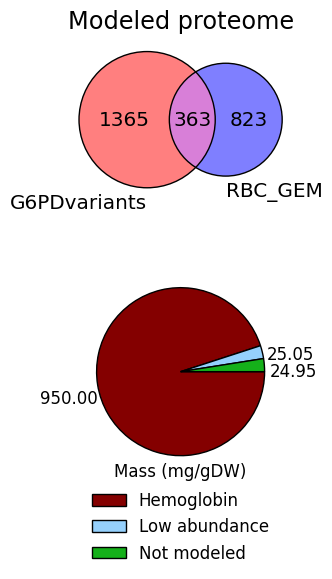

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [23]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(pcmodel, df_samples, df_weights=None, log_zero_replacement=1e-6, verbose=False):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = df_model_data_weights.loc[:, [data_series.name, data_weights.name]].dropna(
            axis=0, how="all"
        ).astype(float)

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)

        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        r2 = r2_score(
            df_qp_sol.iloc[:, 0].values,
            df_qp_sol.iloc[:, 1].values,
            multioutput="uniform_average",
        )
        r2_log10 = r2_score(
            df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10).values,
            df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10).values,
            multioutput="uniform_average",
        )
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, qp_sol.objective_value)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print(
                "R^2 and log10 R^2 (objective) value for Sample '{}': {:.9f} and {:.9f} ({:.5f})".format(
                    sample_id, r2, r2_log10, qp_sol.objective_value
                )
            )
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [24]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_data_weights.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,A1_Post,A1_Pre,A1_TD,A10_Post,A10_Pre,A10_TD,A11_Post,A11_Pre,A11_TD,A12_Post,...,Mean_TD_MED,Median_Post_A,Median_Post_HumCan,Median_Post_MED,Median_Pre_A,Median_Pre_HumCan,Median_Pre_MED,Median_TD_A,Median_TD_HumCan,Median_TD_MED
Entry,,,,,,,,,,,,,,,,,,,,,
A2AAY5,2.233249,2.939803,2.462583,0.198444,2.115449,3.149757,2.402035,1.900613,0.000683,2.169080,...,2.283935,2.405877,2.270142,2.251225,2.304552,2.221793,0.254541,3.050574,2.410132,2.045271
A2ADY9,0.000245,0.000293,0.000098,0.000172,0.000566,0.000135,0.000280,0.000476,0.000149,0.000168,...,0.000351,0.000187,0.000166,0.000189,0.000293,0.000288,0.000252,0.000173,0.000122,0.000147
A2AGT5,2.233249,2.939803,2.462583,2.108584,2.115449,3.149757,2.402035,1.900613,2.654071,2.169080,...,0.651810,2.405877,2.270142,2.251225,2.304552,2.221793,2.261935,3.050574,2.410132,2.045271
A2AN08,0.000633,0.001359,0.000607,0.001177,0.001020,0.000606,0.000826,0.001085,0.000605,0.000619,...,0.002157,0.000768,0.000712,0.000857,0.000945,0.000817,0.001020,0.000674,0.000743,0.000985
A2AQ07,0.000201,0.000108,0.000058,0.000831,0.000335,0.000193,0.000276,1.900613,0.000129,0.000259,...,0.000103,0.000243,0.000399,0.000227,0.000240,0.000221,0.000240,0.000153,0.000109,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2U1,0.000023,0.000023,0.000021,0.000016,0.000015,0.000022,0.000017,0.000015,0.000018,0.000018,...,0.000047,0.000020,0.000018,0.000017,0.000017,0.000017,0.000016,0.000025,0.000021,0.000019
Q9Z2W0,0.000086,0.000117,0.000103,0.000113,0.000078,0.000172,0.000204,0.000065,0.000106,0.000092,...,0.000251,0.000129,0.000108,0.000129,0.000096,0.000106,0.000101,0.000150,0.000102,0.000095
Q9Z2X1,2.233249,0.001097,2.462583,2.108584,2.115449,0.003278,2.402035,1.900613,2.654071,0.001625,...,0.003522,2.405877,2.270142,2.251225,2.304552,2.221793,2.261935,3.050574,2.410132,2.045271


### Fit data by solving QP

In [25]:
run_computations = False
log_zero_replacement = 1e-9
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel, df_samples, df_weights=df_weights, log_zero_replacement=log_zero_replacement, verbose=True
    )

    for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
        fitting_data["measured"][sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        fitting_data["best_fit"][sample_id] = df_qp_sol[
            "Best-Fitted Proteome"
        ].to_dict()
        fitting_data["r2_objective"][sample_id] = {
            "R2": r2,
            "log10_R2": r2_log10,
            "Objective": objective_value,
        }
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index=True)
        fitting_data[key] = data
else:
    for key in fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index_col=0
        )
    qp_solutions_dict = {}
    for sample_id in df_samples.columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2, r2_log10, objective_value = fitting_data["r2_objective"].loc[:, sample_id].values
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, objective_value)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

Number of QP solutions: 125


### Plot fitting 
#### for the mean and median samples of each time point for each phenotype

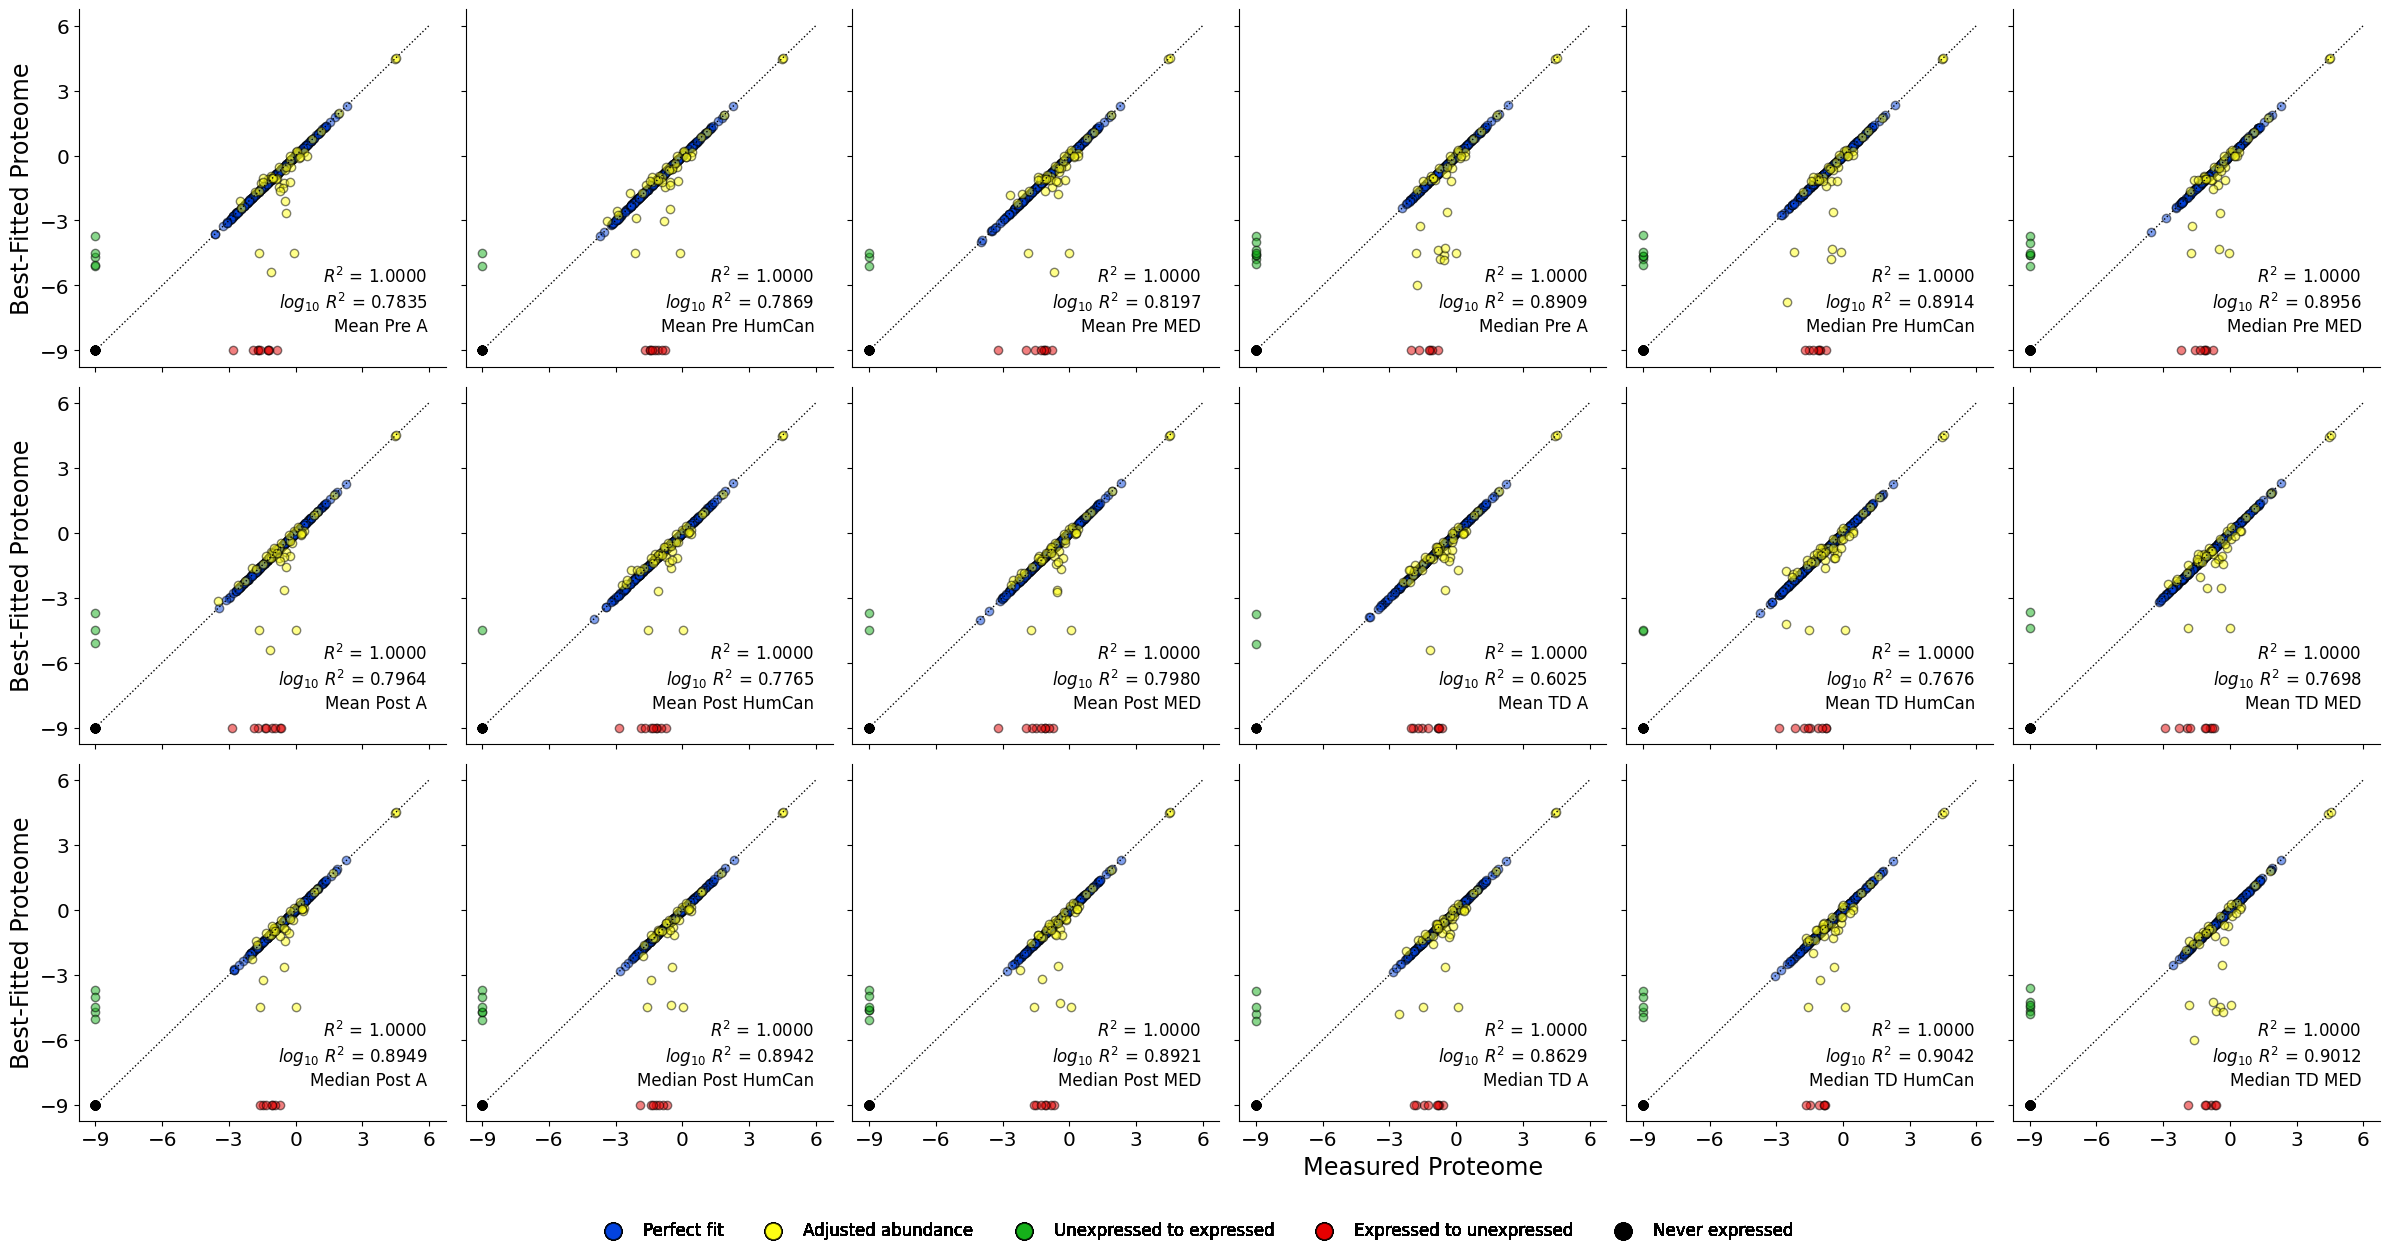

In [26]:
samples_to_plot = np.array(
    [
        # Best for 1 or 3 columns
        [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Mean" in x and "Pre" in x] 
        + [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Median" in x and "Pre" in x],
        [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Mean" in x and "Post" in x]
        + [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Mean" in x and "TD" in x],
        [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Median" in x and "Post" in x]
        + [x for x in operation_ids_dict["TIME_PHENOTYPE"] if "Median" in x and "TD" in x],    ]
)

r2_text_loc = "lower right"
transform = True

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)
for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
    # Copy to prevent alterations to the original
    df_qp_sol = df_qp_sol.copy()
    xlabel, ylabel = df_qp_sol.columns
    
    ticks = 10**np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
    if transform:
        ticks = np.log10(ticks)
        df_qp_sol.iloc[:, 0] = df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
        df_qp_sol.iloc[:, 1] = df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
    perfect_fit_line = ax.plot(
        [ticks[0], ticks[-1]],
        [ticks[0], ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )

    zero_val = 0 if not transform else np.log10(log_zero_replacement)

    df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)]
    df_perfect = df_qp_sol[
        np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]
    
    df_altered = df_qp_sol[
        ~np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], zero_val)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], zero_val)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    op, time, phenotype = str(sample_id.replace(f"{pcmodel.id}_", "")).split("_")
    sample_label = " ".join((op, time, phenotype))

    if not transform:
        ax.set_xscale("log")
        ax.set_yscale("log")

    fontdict = {"size": "xx-large"}
    if idx == len(samples_to_plot.flatten()) - np.ceil(ncols / 2):
        ax.set_xlabel(xlabel, fontdict=fontdict)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="lower center",
        ncols=len(labels),
        frameon=False,
        fontsize="large",
        markerscale=2,
        bbox_to_anchor=(0.5, -0.05),
    )
    if idx % ncols == 0:
        ax.set_ylabel(ylabel, fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    if r2_text_loc == "lower right":
        ax.text(
            0.95,
            0.1,
            "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="right",
        )
    elif r2_text_loc == "upper left":
        ax.text(
            0.05,
            0.9,
            "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="left",
        )
    else:
        pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )


### Determine best value for slack variables

In [27]:
list_of_pcmodels = []
verbose = True
objective_rxns = ["NaKt"]

slack_min = 1e-5  # Slack %
slack_max = 1.5
slack_determination_models = operation_ids_dict["TIME_PHENOTYPE"]
if run_computations:
    for sample_id in slack_determination_models:
        df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
        # Create a copy of the model
        pcmodel_sample = pcmodel.copy()
        pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
        for protdl in pcmodel_sample.reactions.query(
            lambda x: isinstance(x, ProteinDilution)
        ):
            if protdl.id in df_qp_sol.index:
                prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
            else:
                prot_bound = 0
            protdl.bounds = (float(prot_bound), float(prot_bound))
        # Add the relaxation budget with slack = 0 first
        add_relaxation_budget(pcmodel_sample, 0, int(verbose))
        list_of_pcmodels += [pcmodel_sample]

    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_rxns): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_rxns)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    solutions = {
        pcmodel_sample: pd.DataFrame.from_dict(sol)
        for pcmodel_sample, sol in solutions.items()
    }

    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_Mean_Post_A,0.020545,-0.821876,0.046129,0.101297
1,RBC_GEM_PC_Mean_Post_A,0.021040,-0.820734,0.044987,0.101297
2,RBC_GEM_PC_Mean_Post_A,0.021548,-0.819549,0.043871,0.101297
3,RBC_GEM_PC_Mean_Post_A,0.022068,-0.818319,0.042780,0.101297
4,RBC_GEM_PC_Mean_Post_A,0.022600,-0.817043,0.041715,0.101297
...,...,...,...,...,...
3272,RBC_GEM_PC_Median_TD_MED,1.363586,0.035647,0.000051,0.103704
3273,RBC_GEM_PC_Median_TD_MED,1.396480,0.035647,0.000050,0.103704
3274,RBC_GEM_PC_Median_TD_MED,1.430167,0.035647,0.000049,0.103704
3275,RBC_GEM_PC_Median_TD_MED,1.464668,0.035647,0.000048,0.103704


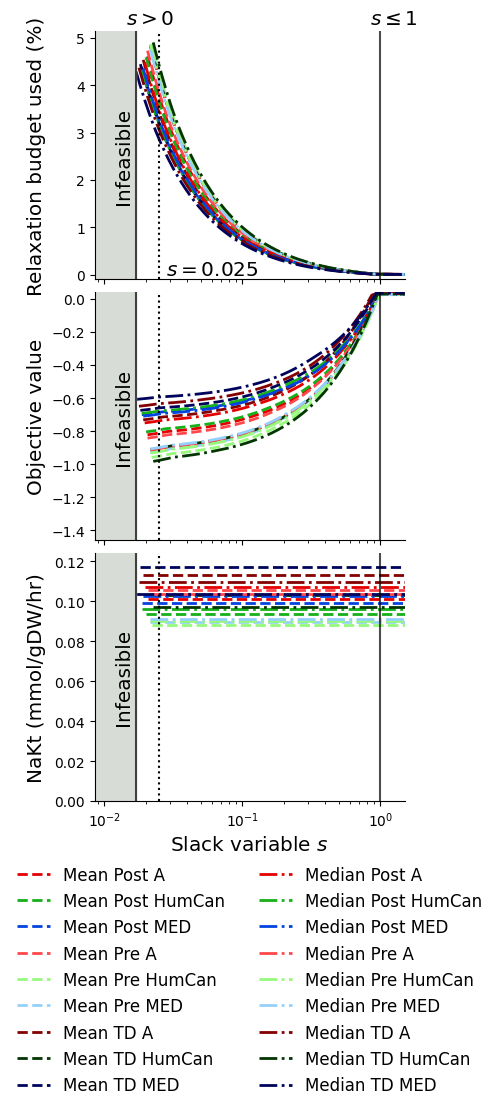

In [28]:
fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()

# ax3d = fig.add_subplot(2, 2, 4, projection="3d")
sns.despine(fig)

handles = []
labels = []
chosen_slack_var = 0.025
colors = {
    ("HumCan", "Pre"): "xkcd:light green",
    ("MED", "Pre"): "xkcd:light blue",
    ("A", "Pre"): "xkcd:light red",

    ("HumCan", "Post"): "xkcd:green",
    ("MED", "Post"): "xkcd:blue",
    ("A", "Post"): "xkcd:red",

    ("HumCan", "TD"): "xkcd:dark green",
    ("MED", "TD"): "xkcd:dark blue",
    ("A", "TD"): "xkcd:dark red",
}
linestyles = {
    "Mean": "--",
    "Median": "-.",
}
use_percents = True
for pcmodel_sample in list(solutions):
    op, time, phenotype = str(pcmodel_sample.replace(f"{pcmodel.id}_", "")).split("_")
    linestyle = linestyles.get(op, ":")
    color = colors.get((phenotype, time), "xkcd:black")
    labels.append("_".join((op, time, phenotype)))
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_rxns)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample}: ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.2
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (
            -0.001 * (100 if use_percents else 1),
            max(r_values) * limit_pad_sclar,
        )
    elif i == 1:
        ymin, ymax = (
            min(0, min(o_values) * 2) * limit_pad_sclar,
            max(o_values) * limit_pad_sclar,
        )
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, 0),
            xycoords="data",
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
labels = [x.replace(f"{pcmodel.id}_", "").replace("_", " ") for x in labels]
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=2,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel("NaKt (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [29]:
list_of_relaxed_models = []
slack_value = chosen_slack_var  # Slack %
verbose = True

# In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}

model_values = {}
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [sample_pcmodels_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]):
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    # # Store model for later use
    # list_of_relaxed_models += [pcmodel_sample]
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Model already created for RBC_GEM_PC_A1_Post
Model already created for RBC_GEM_PC_A1_Pre
Model already created for RBC_GEM_PC_A1_TD
Model already created for RBC_GEM_PC_A10_Post
Model already created for RBC_GEM_PC_A10_Pre
Model already created for RBC_GEM_PC_A10_TD
Model already created for RBC_GEM_PC_A11_Post
Model already created for RBC_GEM_PC_A11_Pre
Model already created for RBC_GEM_PC_A11_TD
Model already created for RBC_GEM_PC_A12_Post
Model already created for RBC_GEM_PC_A12_Pre
Model already created for RBC_GEM_PC_A12_TD
Model already created for RBC_GEM_PC_A2_Post
Model already created for RBC_GEM_PC_A2_Pre
Model already created for RBC_GEM_PC_A2_TD
Model already created for RBC_GEM_PC_A3_Post
Model already created for RBC_GEM_PC_A3_Pre
Model already created for RBC_GEM_PC_A3_TD
Model already created for RBC_GEM_PC_A4_Post
Model already created for RBC_GEM_PC_A4_Pre
Model already created for RBC_GEM_PC_A4_TD
Model already created for RBC_GEM_PC_A5_Post
Model already created 